# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model.

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$).

In this part we will use the **_display_** function to visualize the images.

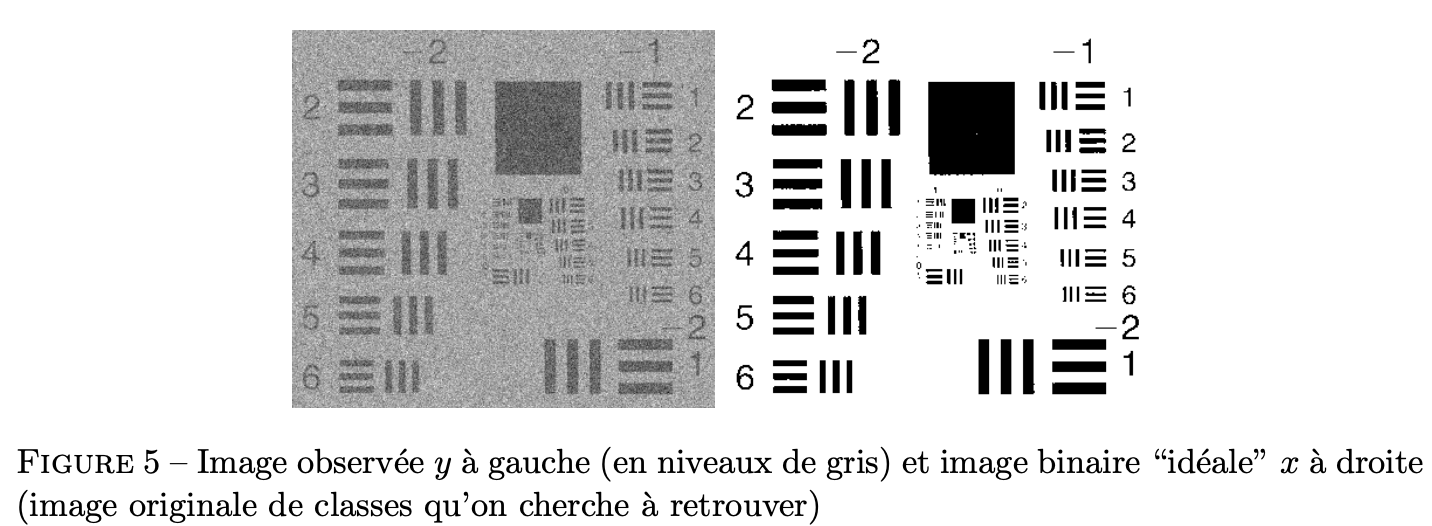

In [1]:
import math
import random
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
import imageio
from scipy import ndimage as ndi
from skimage import io

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[0, im.shape[0]], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=0, dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

The scikit-image library allows to read images from a URL. The "display" function allows to access directly to the grey levels and to the pixels positions by using the mouse.

In [3]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")

affiche(im_obs)

In [4]:
im_ori=io.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')

affiche(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model.
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$

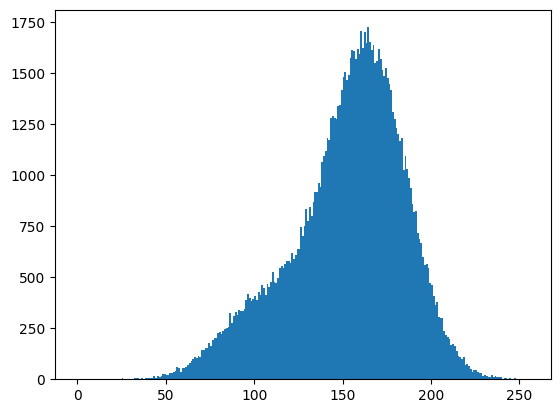

In [5]:
#study of the global distribution of the image
#display of the histogram of the image
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=np.max(im_obs))
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image).

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

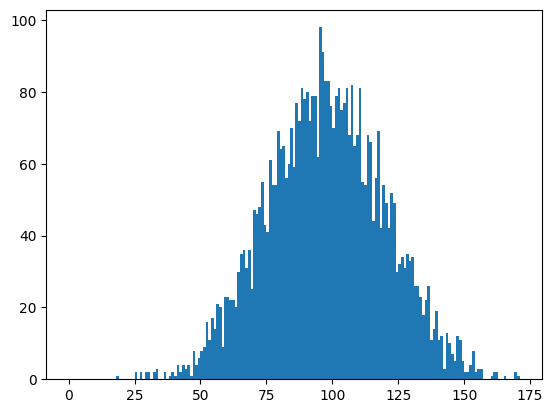

In [7]:
#select a small window in a dark region of the image (class 0)
#be careful, the ordinates correspond to the rows and the abscissas to the columns
N, M = im_obs.shape
crop_classe0 = im_obs[N-270:N-200, 175:240]
#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(), range=[0,np.max(crop_classe0)], bins=np.max(crop_classe0))
plt.show()

In [8]:
#calculate its mean and variance
#
# By default, np.mean, np.zzz takes the two axes of the image.
# You have to force the option if you want to do the average in row or in column
# use np.mean and np.var
m0 = np.mean(crop_classe0)
var0 = np.var(crop_classe0)

print(m0)
print(var0)
print(np.sqrt(var0))

97.05252747252747
492.6436144910034
22.195576462236872


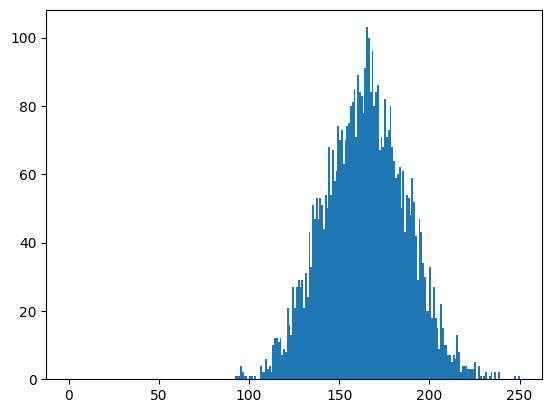

In [9]:
#select a small window in a bright region of the image (class 1)
crop_classe1=im_obs[230:300,130:200]
affiche(crop_classe1)
#plot its histogram
plt.figure()
plt.hist(crop_classe1.ravel(), range=[0,np.max(crop_classe1)], bins=np.max(crop_classe1))
plt.show()

In [10]:
#calculate its mean and variance
m1 = np.mean(crop_classe1)
var1 = np.var(crop_classe1)

print(m1)
print(var1)
print(np.sqrt(var1))

163.87755102040816
512.7315368596419
22.64357606164808


### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated.

### A1

Both distributions follow a Gaussian model: the class 0 follows $\mathcal{N}(\mu_0, \sigma_0^2)$ and class 1, $\mathcal{N}(\mu_1, \sigma_1^2)$, where $(\mu_0, \sigma_0^2) \approx (97, 493)$ and $(\mu_1, \sigma_1^2) \approx (164, 513)$.

### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions.

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2

\begin{align*}
P(Y_s = y_s \mid X_s = 0) &< P(Y_s = y_s \mid X_s = 1) \\
\iff \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{1}{2 \sigma^2} (y_s - \mu_0)^2} &< \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{1}{2 \sigma^2} (y_s - \mu_1)^2} \\
\iff (y_s - \mu_0)^2 &> (y_s - \mu_1)^2 \\
\iff 2 (\mu_1 - \mu_0) y_s &> \mu_1^2 - \mu_0^2 \\
\iff y_s &> \frac{\mu_0 + \mu_1}{2}
\end{align*}

In [10]:
# Set the threshold for classification in the ML sense and display the image
threshold = (m1 + m0) / 2
im_bin = im_obs.copy()
im_bin = np.where(im_bin < threshold, 0, 1)
affiche(im_bin)

### Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$

### A3
\begin{align*}
U_\text{attdo} &= \sum_s - \log{(P(Y_s = y_s \mid X_s = x_s))} \\
&= \sum_s - \left( - \log{(\sqrt{2 \pi \sigma_{x_s}^2})} - \frac{1}{2 \sigma_{x_s}^2} (y_s - \mu_{x_s})^2 \right) \\
&= \sum_s \frac{(y_s - \mu_{x_s})^2}{2 \sigma_{x_s}^2} + \log{(\sqrt{2 \pi \sigma_{x_s}^2})}
\end{align*}

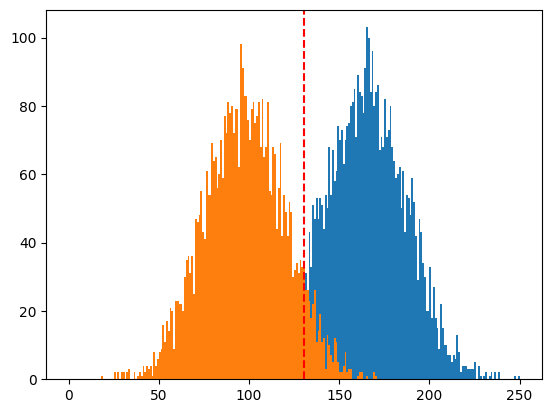

In [11]:
plt.hist(crop_classe1.ravel(), range=[0,np.max(crop_classe1)], bins=np.max(crop_classe1))
plt.hist(crop_classe0.ravel(), range=[0,np.max(crop_classe0)], bins=np.max(crop_classe0))
plt.axvline(x=threshold, color='red', linestyle='--')
plt.show()

## 2 Ising model for regularisation and energies
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise.
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously.

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4

To simplify the writing of the energy as much as possible, we are assuming that the variance is constant between the classes.

- _potential_:

$$
U(x_s, x_t) = \beta \Delta(x_s, x_t)
$$

- _global energy_:

\begin{align*}
\mathcal{U}(x \mid y) &= U_\text{attdo} + \sum_{c \in \mathcal{C}} U(x_s, x_t) \\
&= \underbrace{\sum_s \frac{(y_s - \mu_{x_s})^2}{2 \sigma^2} + \log{(\sqrt{2 \pi \sigma^2})}}_\text{data fidelity} + \underbrace{\sum_{c \in \mathcal{C}} \beta \Delta(x_s, x_t)}_\text{regularization}
\end{align*}

- _local conditional energy_:

$$
\mathcal{U}(x_s \mid y_s, \mathcal{V}_s) = \underbrace{\log{(\sqrt{2 \pi \sigma^2})} + \frac{(y_s - \mu_{x_s})^2}{2 \sigma^2}}_\text{data fidelity} + \underbrace{\sum_{r \in \mathcal{V}_s} \beta \Delta(x_s, r)}_\text{regularization}
$$

### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

### A5

\begin{align*}
\mathcal{U}(0 \mid 105, (0, 1, 1, 1)) &\propto (105 - 97.05)^2 + 3 \beta = 63.2025 + 3 \beta \\
\mathcal{U}(1 \mid 105, (0, 1, 1, 1)) &\propto (105 - 163.87)^2 + \beta = 3465.6769 + \beta
\end{align*}

### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?

### A6

$$
\mathcal{U}(0 \mid 105, (0, 1, 1, 1)) < \mathcal{U}(1 \mid 105, (0, 1, 1, 1)) \iff \beta < 1701.23.
$$

So, if $\beta < 1701.2372$, the assigned class is $0$. Otherwise, it is $1$.

### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7

When $\beta = 0$, there is no regularization, so the solution is the same as the one computed in Q2.

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8

When $\beta \to + \infty$, the dominant term is always the regularization, so $x$ will have all pixels of the same class (either $0$ or $1$).

### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model.

### A9

As $\beta$ increases, the regularization component gains more and more influence over the solution. Without regularization, as seen in question 2, the classification tends to be less effective, especially in degraded images (like those affected by noise).

The purpose of this Markovian model is to enhance classification by balancing the influence of the data fidelity term with regularization, which relies on the local neighborhood's properties.

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  

Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image).

In [14]:
def iter_icm(im_bin, im_toclass, beta_reg, m0, m1):
    N, M = im_toclass.shape[:2]

    for i in range(N):
        for j in range(M):
            # do not change these indices they allow access to neighboring pixels
            i1 = (i - 1) % N
            i2 = (i + 1) % N
            j1 = (j - 1) % M
            j2 = (j + 1) % M

            # energy computation if the pixel is put in class 0
            Delta0 = np.sum(im_bin[[i1, i2, i, i], [j, j, j1, j2]] != 0)
            U0 = (im_toclass[i, j] - m0)**2 + beta_reg * Delta0

            # energy computation if the pixel is put in class 1
            Delta1 = np.sum(im_bin[[i1, i2, i, i], [j, j, j1, j2]] != 1)
            U1 = (im_toclass[i, j] - m1)**2 + beta_reg * Delta1

            if U1 > U0:
                im_bin[i,j] = 0
            else:
                im_bin[i,j] = 1

    return im_bin


### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

### A10

A good initialization would be the solution without regularization. This is because it is relatively close to the final solution and its computational time complexity is linear on the number of pixels ($\mathcal{O}(M N)$).

Implement the ICM and study the influence of $\beta$.

In [15]:
# ICM algorithm to be implemented

def icm(im_obs, beta, m0, m1, iters=100):
    #define the value of beta_reg to have a "good" regularization
    beta_reg = beta
    #initialise the binary image of the classes
    T = (m0 + m1) / 2
    im_bin = np.where(im_obs < T, 0, 1)

    # program a loop in which we call iter_icm
    # and display the class image as iterations are performed
    for n in range(iters):
        iter_icm(im_bin, im_obs, beta_reg, m0, m1)
        
    return im_bin

In [32]:
%%time
affiche(icm(im_obs, 1_701, m0, m1, 20))

CPU times: user 15 s, sys: 229 ms, total: 15.2 s
Wall time: 15 s


### Q12
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.

### A12

You can compare your result with the original image to find the right regularisation parameter.

In [35]:
#use np.abs to calculate the absolute value of the difference
# between the original binary image and the ICM result
# note: im_bin is coded between 0 and 1 and im_ori between 0 and 255
def diff(img0, img1):
    return np.mean(np.abs(img1 - img0))

betas = np.linspace(100, 2_200, 240)
diffs = []

for beta in betas:
    print(beta)
    diffs.append(diff(im_ori, icm(im_obs, beta, m0, m1, 20)))

100.0
108.7866108786611
117.57322175732217
126.35983263598327
135.14644351464435
143.93305439330544
152.71966527196653
161.50627615062763
170.2928870292887
179.07949790794981
187.86610878661088
196.65271966527197
205.43933054393307
214.22594142259413
223.01255230125525
231.79916317991632
240.5857740585774
249.3723849372385
258.15899581589963
266.94560669456064
275.73221757322176
284.5188284518829
293.30543933054395
302.092050209205
310.87866108786613
319.6652719665272
328.45188284518827
337.2384937238494
346.0251046025105
354.8117154811716
363.59832635983264
372.38493723849376
381.1715481171548
389.9581589958159
398.744769874477
407.5313807531381
416.3179916317992
425.10460251046027
433.89121338912133
442.67782426778246
451.4644351464435
460.25104602510464
469.0376569037657
477.8242677824268
486.6108786610879
495.39748953974896
504.1841004184101
512.9707112970711
521.7573221757323
530.5439330543934
539.3305439330544
548.1171548117155
556.9037656903765
565.6903765690377
574.476987447698

2094.560669456067


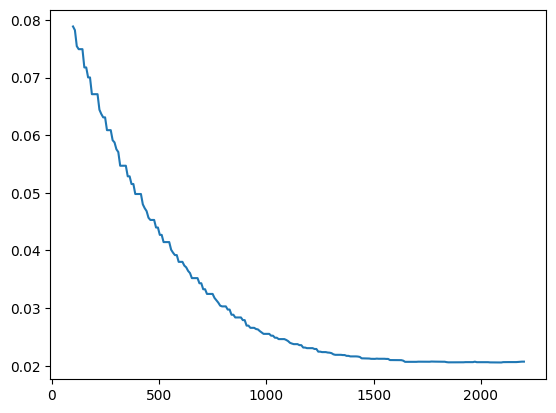

In [36]:
plt.plot(betas, diffs)
print(betas[np.argmin(diffs)])

In [38]:
betas = np.linspace(800, 3_000, 30)
diffs = []

for beta in betas:
    print(beta)
    diffs.append(diff(im_ori, icm(im_obs, beta, m0, m1, 20)))

800.0
875.8620689655172
951.7241379310344
1027.5862068965516
1103.4482758620688
1179.310344827586
1255.1724137931035
1331.0344827586207
1406.896551724138
1482.7586206896551
1558.6206896551723
1634.4827586206898
1710.344827586207
1786.2068965517242
1862.0689655172414
1937.9310344827586
2013.7931034482758
2089.655172413793
2165.5172413793102
2241.3793103448274
2317.2413793103447
2393.1034482758623
2468.9655172413795
2544.8275862068967
2620.689655172414
2696.551724137931
2772.4137931034484
2848.2758620689656
2924.137931034483
3000.0


2089.655172413793


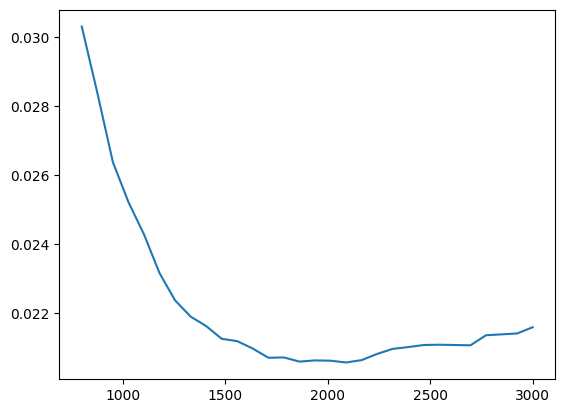

In [39]:
plt.plot(betas, diffs)
print(betas[np.argmin(diffs)])

In [46]:
betas = np.linspace(2089, 2100, 12)
diffs = []

for beta in betas:
    print(beta)
    diffs.append(diff(im_ori, icm(im_obs, beta, m0, m1, 20)))

2089.0
2090.0
2091.0
2092.0
2093.0
2094.0
2095.0
2096.0
2097.0
2098.0
2099.0
2100.0


2089.0


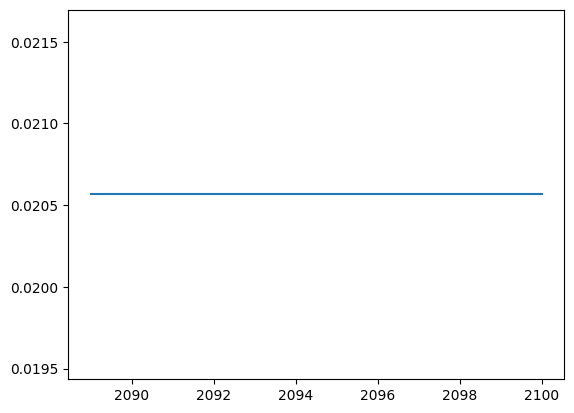

In [50]:
plt.plot(betas, diffs)
print(betas[np.argmin(diffs)])

### Q13
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

In [42]:
def icm_random(im_obs, beta, m0, m1, iters=100):
    im_bin = np.random.randn(*im_obs.shape)

    for n in range(iters):
        iter_icm(im_bin, im_obs, beta, m0, m1)

    return im_bin


def icm_zeros(im_obs, beta, m0, m1, iters=100):
    im_bin = np.zeros(im_obs.shape)

    for n in range(iters):
        iter_icm(im_bin, im_obs, beta, m0, m1)

    return im_bin


def icm_ones(im_obs, beta, m0, m1, iters=100):
    im_bin = np.ones(im_obs.shape)

    for n in range(iters):
        iter_icm(im_bin, im_obs, beta, m0, m1)

    return im_bin

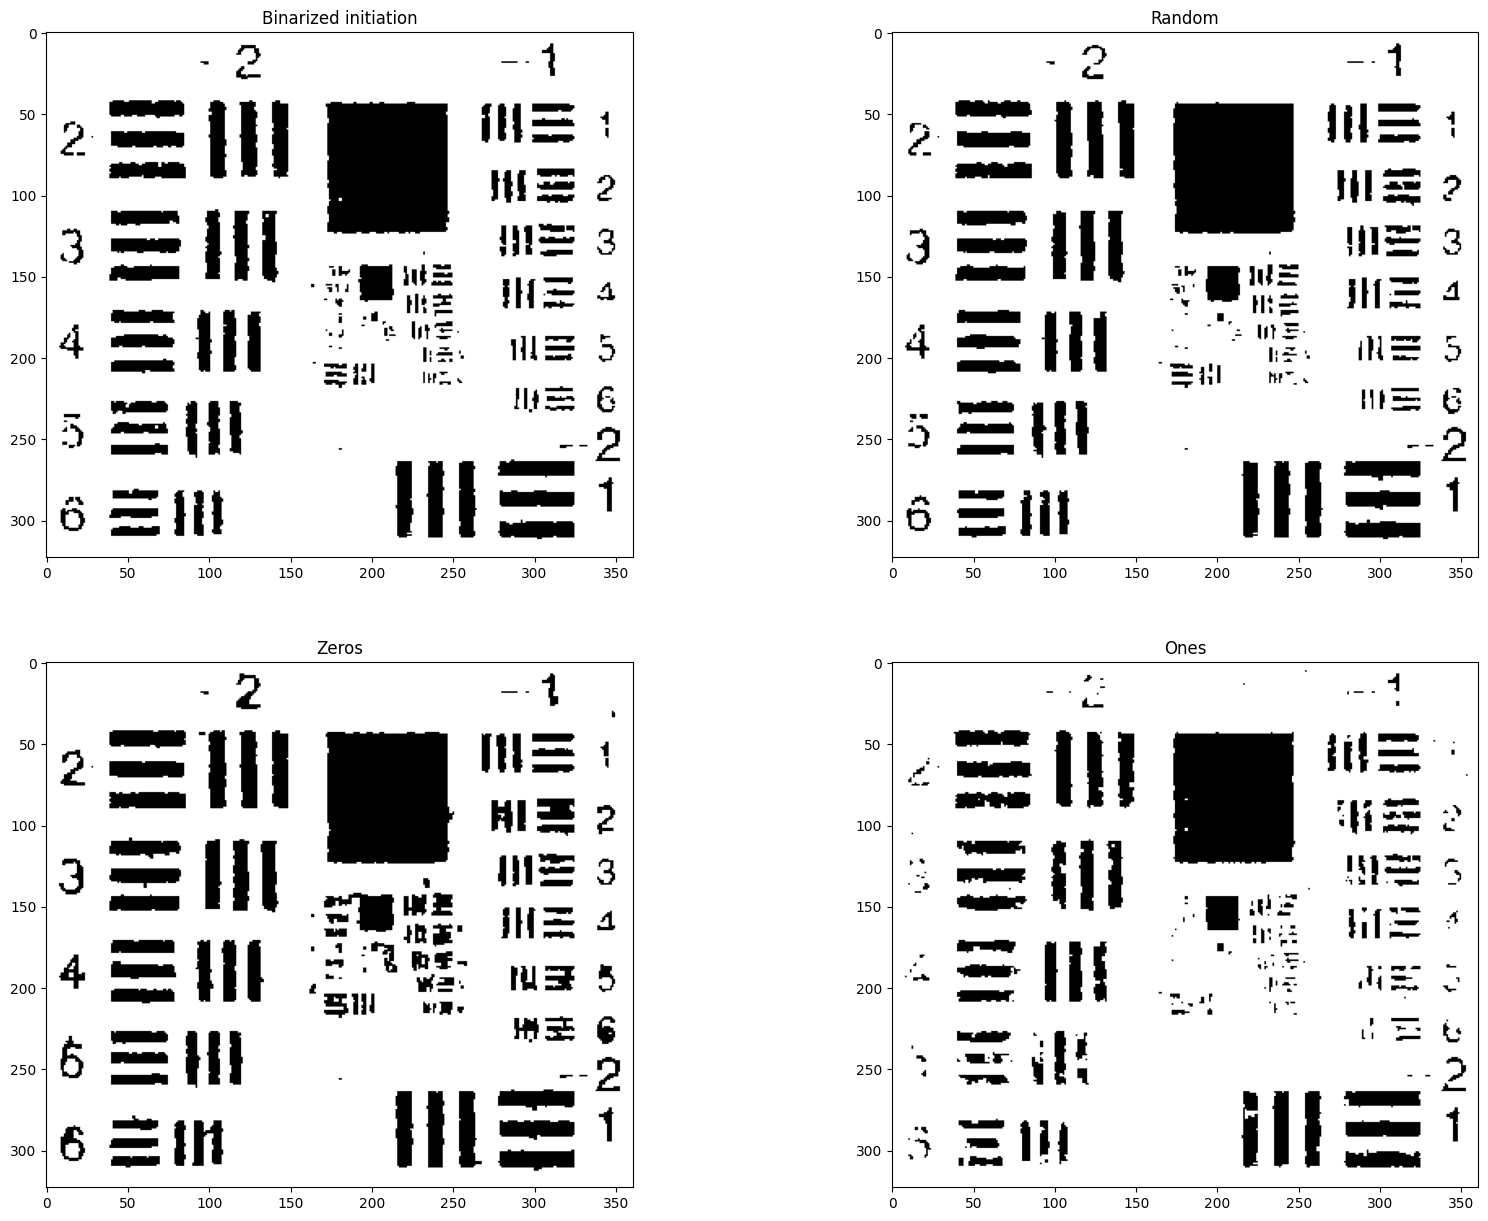

In [51]:
fig = plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
plt.imshow(icm(im_obs, 2095, m0, m1, 20), cmap='gray')
plt.title('Binarized initiation')

plt.subplot(2, 2, 2)
plt.imshow(icm_random(im_obs, 2095, m0, m1, 20), cmap='gray')
plt.title('Random')

plt.subplot(2, 2, 3)
plt.imshow(icm_zeros(im_obs, 2095, m0, m1, 20), cmap='gray')
plt.title('Zeros')

plt.subplot(2, 2, 4)
plt.imshow(icm_ones(im_obs, 1701, m0, m1, 20), cmap='gray')
plt.title('Ones')

plt.show()

### A13

We see that all initialization methods converge to approximately the same solution. However, we noticed that in the case of constant images, the regularization parameter $\beta$ has to be smaller, to make the data fidelity term more "apparent". Similarly, with random initialization, $\beta$ has to be greater.

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [11]:
def echan_r(im_bin, im_toclass, beta_reg, m0, m1, T):
    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            i1 = (i - 1) % N
            i2 = (i + 1) % N
            j1 = (j - 1) % M
            j2 = (j + 1) % M

            Delta0 = np.sum(im_bin[[i1, i2, i, i], [j, j, j1, j2]] != 0)
            U0 = (im_toclass[i, j] - m0)**2 + beta_reg * Delta0
            p0 = math.exp(- U0 / T)

            Delta1 = np.sum(im_bin[[i1, i2, i, i], [j, j, j1, j2]] != 1)
            U1 = (im_toclass[i, j] - m1)**2 + beta_reg * Delta1
            p1 = math.exp(- U1 / T)

            Z = p0 + p1

            if (Z != 0.):
                if(random.uniform(0, 1) < p0 / Z):
                    im_bin[i, j] = 0
                else:
                    im_bin[i, j] = 1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough.

In [19]:
# Program the simulated annealing
#temperature initialization
# initial temperature
def annealing(im_obs, beta, m0, m1, T):
    #initialization of the binary image
    im_bin = np.where(im_obs < (m0 + m1) / 2, 0, 1)

    # make a loop by calling the function that does a Gibbs sampling at T
    for t in T:
        print(t)
        echan_r(im_bin, im_obs, beta, m0, m1, t)
    return im_bin

affiche(annealing(im_obs, 2095, m0, m1, 1020 * (0.96) ** np.linspace(0, 20, 21)))

1020.0
979.1999999999999
940.0319999999999
902.4307199999998
866.3334911999999
831.6801515519999
798.4129454899198
766.476427670323
735.81737056351
706.3846757409697
678.1292887113308
651.0041171628776
624.9639524763625
599.9653943773079
575.9667786022155
552.928107458127
530.8109831598018
509.5785438334097
489.19540208007334
469.6275859968704
450.84248255699555


### Q14
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

In [48]:
im_icm = icm(im_obs, 2095, m0, m1, 20)
im_annealing = annealing(im_obs, 2095, m0, m1, 1020 * (0.96) ** np.linspace(0, 20, 21))

diff_icm = np.mean(np.abs(im_ori - im_icm))
diff_annealing = np.mean(np.abs(im_ori - im_annealing))

print(diff_icm)
print(diff_annealing)

0.19355419671878082


In [49]:
affiche(im_annealing)

### A14

The results obtained with ICM and annealing are quite similar and consistent with the results seen in the course.
However, the average absolute difference between the predicted classes $x$ and the original "perfect" prediction is smaller for the annealing algorithm, which shows its superiority.